In [1]:
%config Completer.use_jedi = False

from field_importer import get_field
import mask
from cartoplot import cartoplot
from select_type import select_type
import numpy as np
import tqdm
import datetime
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import cartopy
from regrid import regrid
from importlib import reload
from mask import select_region
from netCDF4 import Dataset

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [2]:
d = Dataset('/media/robbie/TOSHIBA_EXT/weekly_NSIDC_age/iceage_nh_12.5km_19840101_19841231_v4.1.nc')
lons = np.array(d['longitude'])
lats = np.array(d['latitude'])
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    version: 4.1
    release_date: April 2019
    Conventions: CF-1.4
    citation: Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhancement to sea ice motion and age products, The Cryosphere Discuss., https://doi.org/10.5194/tc-2019-40, in review, 2019.
    dataset_doi: 10.5067/UTAV7490FEPB
    dimensions(sizes): x(722), y(722), time(52)
    variables(dimensions): float32 x(x), float32 y(y), float64 time(time), int32 crs(), uint8 age_of_sea_ice(time,y,x), float32 latitude(y,x), float32 longitude(y,x)
    groups: 

# Make Chukchi and Basin 722 masks

In [3]:
persistent_ice = pickle.load(open('../pickles/sz.p','rb'))


In [4]:
ones_361 = np.ones((361,361))

ease_lons, ease_lats = mask.get('lon'), mask.get('lat')

chuk = mask.select_region('Beaufort', ones_361)

# chuk[persistent_ice!=1] = np.nan

basin = mask.select_region('basin', ones_361)

chuk_722 = regrid(chuk,ease_lons,ease_lats,lons,lats)

basin_722 = regrid(basin,ease_lons,ease_lats,lons,lats)

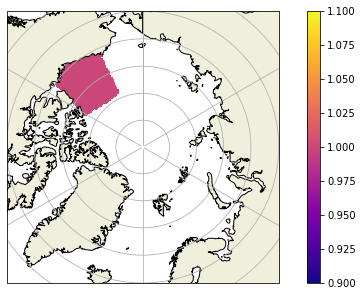

In [5]:
cartoplot(lons,lats,chuk_722)

 95%|█████████▍| 36/38 [00:01<00:00, 25.96it/s]

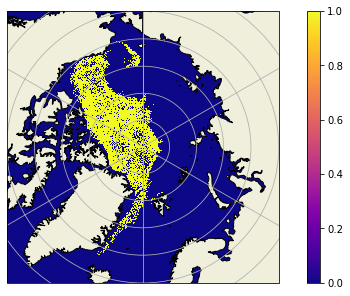

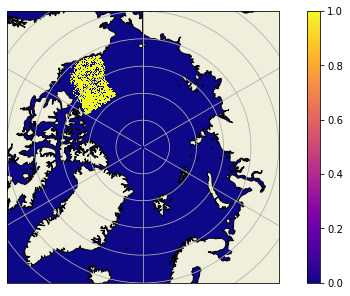

100%|██████████| 38/38 [00:02<00:00, 12.74it/s]


In [6]:
myi_areas = []

MYI_arrays = []

for year in tqdm.trange(1984,2022):
    
    if year != 2021:
        d = Dataset(f'/media/robbie/TOSHIBA_EXT/weekly_NSIDC_age/iceage_nh_12.5km_{year}0101_{year}1231_v4.1.nc')
        age = np.array(d['age_of_sea_ice'][8])
    elif year == 2021:
        d = Dataset('/media/robbie/TOSHIBA_EXT/weekly_NSIDC_age/iceage_nh_12.5km_20200101_20210304_ql.nc')
        age = np.array(d['age_of_sea_ice'][52+8])


    MYI_pixels = np.ones(age.shape)
    
    MYI_pixels[age<2] = 0
    MYI_pixels[age>15] = 0
#     MYI_pixels[basin_722 != 1] = 0
    
    MYI_chuk = MYI_pixels.copy()
    MYI_chuk[chuk_722 != 1] = 0
    
    
    if year == 2021:
        cartoplot(lons,lats,MYI_pixels)
        cartoplot(lons,lats,MYI_chuk)

    MYI_arrays.append(MYI_pixels)
    
    chuk_area = np.count_nonzero(np.nan_to_num(MYI_chuk))
    basin_area = np.count_nonzero(np.nan_to_num(MYI_pixels))
    
    myi_areas.append(chuk_area/basin_area)

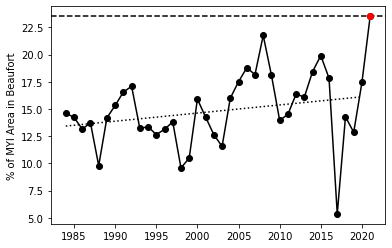

In [7]:
fig, ax  = plt.subplots(1,1,)


ax.plot(np.arange(1984,2022),np.array(myi_areas[:])*100,color='k',marker='o')

ax.scatter(2021,np.array(myi_areas)[-1]*100,color='r',marker='o',zorder=5)

z = np.polyfit(np.arange(1984,2021), myi_areas[:-1], 1)
p = np.poly1d(z)

trendline = p(np.arange(1984,2021))*100

ax.plot(np.arange(1984,2021), trendline,color='k',ls=':')

ax.axhline(myi_areas[-1]*100,color='k',ls='--')

ax.set_ylabel('% of MYI Area in Beaufort')

overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/Beaufort'
plt.savefig(f'{overleaf_dir}/Sup_figs/myi_panel.jpg',dpi=500,bbox_inches='tight')

plt.show()

2.063427650003487


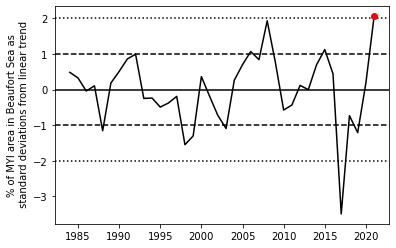

In [8]:
fig, ax  = plt.subplots(1,1,)

z = np.polyfit(np.arange(1984,2022), myi_areas, 1)
p = np.poly1d(z)

trendline = p(np.arange(1984,2022))*100

anoms = np.array(myi_areas)*100-trendline

anoms_std = np.std(anoms)

print((anoms/anoms_std)[-1])

ax.plot(np.arange(1984,2022),anoms/anoms_std,color='k')

ax.scatter([2021],(anoms/anoms_std)[-1:],color='r',zorder=5)

ax.set_ylabel('% of MYI area in Beaufort Sea as\n standard deviations from linear trend')

ax.axhline(0,color='k',ls='-')

ax.axhline(-1,color='k',ls='--')
ax.axhline(1,color='k',ls='--')


ax.axhline(-2,color='k',ls=':')
ax.axhline(2,color='k',ls=':')

overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/Beaufort'
plt.savefig(f'{overleaf_dir}/Sup_figs/MYI_frac_as_anom.jpg',dpi=500,bbox_inches='tight')

plt.show()

In [9]:
pickle.dump(myi_areas, open('beaufort_myi_frac.p','wb'))

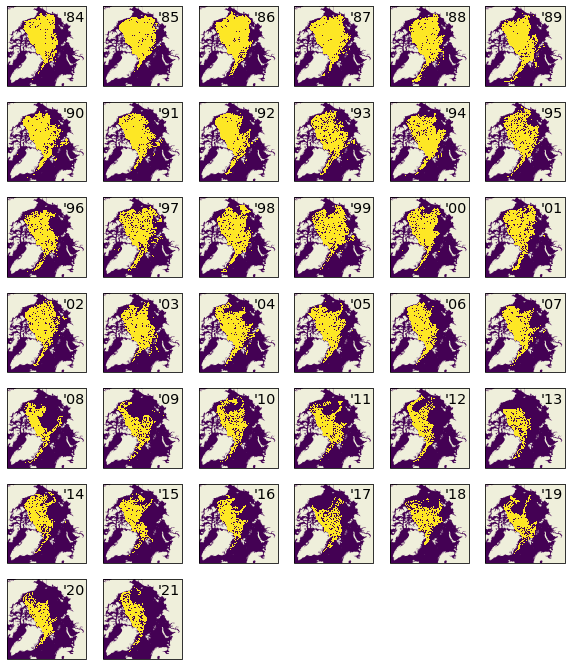

In [11]:
fig, axs = plt.subplots(7,6,figsize=(10,12), subplot_kw={'projection': ccrs.NorthPolarStereo()})

for counter, year in enumerate(np.arange(1984,2022)):
    
    ax = axs.reshape(-1)[counter]
    
    ax.add_feature(cartopy.feature.LAND,
#                    edgecolor='gray',
                   edgecolor=None,
                   zorder=1)

    ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())    
    
    ax.annotate(f"'{str(year)[-2:]}", xy=(0.98,0.95), ha='right',va='top',
                xycoords='axes fraction',fontsize='x-large')

    ax.pcolormesh(lons,
                lats,
                MYI_arrays[counter][:-1,:-1],
                transform=ccrs.PlateCarree(),
                
                )
    
    
for ax in axs.reshape(-1)[-4:]:
    ax.remove()
    
# overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/Beaufort'
# plt.savefig(f'{overleaf_dir}/Sup_figs/annual_MYI_dist.jpg',dpi=500,bbox_inches='tight')


    

In [7]:
d = Dataset('/home/robbie/Dropbox/beaufort_sea/iceage_nh_12.5km_20210101_20210701_ql.nc')
d

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    version: Quicklook data based on Quicklook Ice Motion input
    release_date: August 2021
    Conventions: CF-1.4
    citation: Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhancement to sea ice motion and age products, The Cryosphere Discuss., https://doi.org/10.5194/tc-2019-40, in review, 2019.
    dataset_doi: 10.5067/2XXGZY3DUGNQ
    dimensions(sizes): x(722), y(722), time(31)
    variables(dimensions): float32 x(x), float32 y(y), float64 time(time), int32 crs(), uint8 age_of_sea_ice(time,y,x), float32 latitude(y,x), float32 longitude(y,x)
    groups: 

# Old stuff starts here

 84%|████████▍ | 32/38 [00:00<00:00, 104.94it/s]

(31, 722, 722)


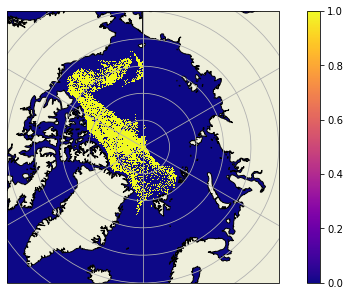

100%|██████████| 38/38 [00:01<00:00, 34.17it/s] 


In [16]:
myi_areas = []

MYI_arrays = []

wk = 30

for year in tqdm.trange(1984,2022):
    
    if year != 2021:
        d = Dataset(f'/media/robbie/TOSHIBA_EXT/weekly_NSIDC_age/iceage_nh_12.5km_{year}0101_{year}1231_v4.1.nc')
        age = np.array(d['age_of_sea_ice'][wk])
    elif year == 2021:
        d = Dataset('/home/robbie/Dropbox/beaufort_sea/iceage_nh_12.5km_20210101_20210701_ql.nc')
        age = np.array(d['age_of_sea_ice'][wk])
        
        print(d['age_of_sea_ice'].shape)


    MYI_pixels = np.ones(age.shape)
    
    MYI_pixels[age<2] = 0
    MYI_pixels[age>15] = 0
        
    if year == 2021:
        cartoplot(lons,lats,MYI_pixels)

    MYI_arrays.append(MYI_pixels)
    
#     chuk_area = np.count_nonzero(np.nan_to_num(MYI_chuk))
    basin_area = np.count_nonzero(np.nan_to_num(MYI_pixels))
    
    myi_areas.append(basin_area)

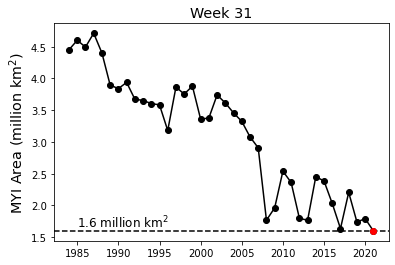

In [27]:
fig, ax  = plt.subplots(1,1,)


ax.plot(np.arange(1984,2022),np.array(myi_areas[:])*157.1/1e6,color='k',marker='o')

ax.scatter(2021,np.array(myi_areas)[-1]*157.1/1e6,color='r',marker='o',zorder=5)

# z = np.polyfit(np.arange(1984,2021), myi_areas[:-1], 1)
# p = np.poly1d(z)
# trendline = p(np.arange(1984,2021))*100
# ax.plot(np.arange(1984,2021), trendline,color='k',ls=':')

ax.axhline(myi_areas[-1]*157.1/1e6,color='k',ls='--')
ax.annotate(text = f'{np.round(np.array(myi_areas)[-1]*157.1/1e6, decimals=2)} million km$^2$',
            xycoords = 'data',
            xy = (1985,np.array(myi_areas)[-1]*158/1e6),
            va='bottom',
            fontsize='large')

ax.set_title(f'Week {wk+1}', fontsize='x-large')

ax.set_ylabel('MYI Area (million km$^2$)', fontsize='x-large')

plt.savefig(f'wk{wk}.jpg',dpi=500,bbox_inches='tight')

plt.show()

In [11]:
# fig, axs = plt.subplots(7,6,figsize=(10,12), subplot_kw={'projection': ccrs.NorthPolarStereo()})

# for counter, year in enumerate(np.arange(1984,2022)):
    
#     ax = axs.reshape(-1)[counter]
    
#     ax.add_feature(cartopy.feature.LAND, edgecolor='gray',zorder=1)

#     ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())    
    
#     ax.annotate(f"'{str(year)[-2:]}", xy=(0.98,0.95), ha='right',va='top',
#                 xycoords='axes fraction',fontsize='x-large')

#     ax.pcolormesh(lons,
#                 lats,
#                 MYI_arrays[counter][:-1,:-1],
#                 transform=ccrs.PlateCarree(),
                
#                 )
    
# for ax in axs.reshape(-1)[-4:]:
#     ax.remove()
    

In [19]:
myi_areas2 = []

MYI_arrays = []

for year in tqdm.trange(1984,2022):
    
    wk_list = []
    
    r = range(31) if year == 2021 else range(52)
    
    for week in r:
    
        if year != 2021:
            d = Dataset(f'/media/robbie/TOSHIBA_EXT/weekly_NSIDC_age/iceage_nh_12.5km_{year}0101_{year}1231_v4.1.nc')
            age = np.array(d['age_of_sea_ice'][week])
        elif year == 2021:
            d = Dataset('/home/robbie/Dropbox/beaufort_sea/iceage_nh_12.5km_20210101_20210701_ql.nc')
            age = np.array(d['age_of_sea_ice'][week])



        MYI_pixels = np.ones(age.shape)

        MYI_pixels[age<2] = 0
        MYI_pixels[age>15] = 0

        basin_area = np.count_nonzero(np.nan_to_num(MYI_pixels))
        
        wk_list.append(basin_area)
    
    myi_areas2.append(wk_list)

100%|██████████| 38/38 [00:17<00:00,  2.21it/s]


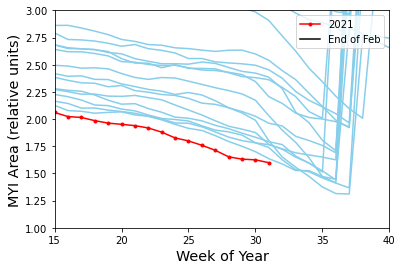

In [20]:
fig, ax  = plt.subplots(1,1,)

for counter, year in enumerate(np.arange(1984,2022)):
    
    wk_list = myi_areas2[counter]
    
    if year == 2021:
        color = 'r'
        marker='.'
        label='2021'
    else:
        color = 'skyblue'
        marker=None
        label=None
    
    ax.plot(np.arange(1,len(wk_list)+1),
            np.array(wk_list)*157.1/1e6,
            color=color,marker=marker,label=label)

# ax.axhline(wk_list[-1],color='k',ls='--')

ax.set_ylabel('MYI Area (relative units)', fontsize='x-large')

ax.axvline(8.5,color='k',label='End of Feb')

ax.set_xlabel('Week of Year', fontsize='x-large')

ax.legend(loc='upper right')

ax.set_xlim(15,40)
ax.set_ylim(1,3)

plt.show()

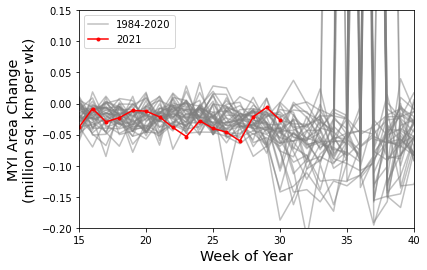

In [39]:
fig, ax  = plt.subplots(1,1,)

for counter, year in enumerate(np.arange(1984,2022)):
    
    wk_list = myi_areas2[counter]
    
    if year == 2021:
        color = 'r'
        marker='.'
        label='2021'
        alpha=1
    elif year == 2020:
        color = 'gray'
        marker=None
        label='1984-2020'
        alpha=0.5
    else:
        color = 'gray'
        marker=None
        label=None
        alpha=0.5
    
    ax.plot(np.arange(1,len(wk_list)),
            np.diff(np.array(wk_list)*157.1/1e6),
            color=color,marker=marker,label=label,
            alpha=alpha)

# ax.axhline(wk_list[-1],color='k',ls='--')

ax.set_ylabel('MYI Area Change\n(million sq. km per wk)', fontsize='x-large')

# ax.axvline(8.5,color='k',label='End of Feb')

ax.set_xlabel('Week of Year', fontsize='x-large')

ax.legend(loc='upper left')

ax.set_xlim(15,40)
ax.set_ylim(-0.2,0.15)

plt.show()

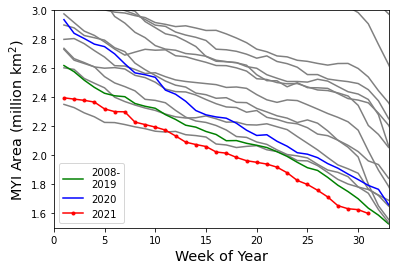

In [23]:
fig, ax  = plt.subplots(1,1,)

for counter, year in enumerate(np.arange(1984,2022)):
    
    wk_list = myi_areas2[counter]
    
    if year == 2021:
        color = 'r'
        marker='.'
        label='2021'
        
    elif year == 2020:
        color = 'blue'
        label='2020'
        
    elif year == 2017:
        color = 'green'
        label='2020'
        
    else:
        color = 'gray'
        marker=None
        label=None
    if year == 2017:
        label='2008-\n2019'
    
    ax.plot(np.arange(1,len(wk_list)+1),np.array(wk_list)*157.1/1e6,color=color,marker=marker,label=label)

# ax.axhline(wk_list[-1],color='k',ls='--')

ax.set_ylabel('MYI Area (million km$^2$)', fontsize='x-large')

# ax.axvline(8.5,color='k',label='End of Feb')

ax.set_xlabel('Week of Year', fontsize='x-large')

ax.legend(loc='lower left')

ax.set_ylim(1.5,3)

ax.set_xlim(0,33)

plt.savefig(f'wk26_lines.jpg',dpi=500,bbox_inches='tight')

plt.show()

# Verify with OSISAF data

In [37]:
def get_OSI_type_on_date(date):
    
    day = str(date.day).zfill(2)
    month = str(date.month).zfill(2)
    year = str(date.year)
    file = f'/media/robbie/TOSHIBA_EXT/OSISAF_type/type/{year}/{month}/ice_type_nh_polstere-100_multi_{year}{month}{day}1200.nc'
    #     file = f'/media/robbie/TOSHIBA EXT/OSISAF_type/type/{year}/{month}/ice_type_nh_polstere-100_multi_{year}{month}{day}1200.nc'
    
    with Dataset(file, 'r') as d:
    
        si_type = np.array(d['ice_type'][0])
        
    return(si_type)

with Dataset('/media/robbie/TOSHIBA_EXT/OSISAF_age/ice_type_nh_polstere-100_multi_202012071200.nc') as d:
#     print(d)
    osi_lons = np.array(d['lon'])
    osi_lats = np.array(d['lat'])
    print(osi_lats.shape)

d = datetime.date(year=2021,month=2,day=25)

dat = get_OSI_type_on_date(d)

(1120, 760)


In [169]:
week = 5

fracs = []
coms = []
sept_areas = []
years = range(2006,2021)

ones = np.ones(osi_lons.shape)

good_mask_vals = [8,9,10,11,12,13,15]

for year in years:
    
    print(year)
    if year < 2021:
        with Dataset(f'/media/robbie/TOSHIBA EXT/weekly_NSIDC_age/iceage_nh_12.5km_{year}0101_{year}1231_v4.1.nc') as d:

            sep_ice = np.array(d['age_of_sea_ice'][35])
#     else:
#         with Dataset('/media/robbie/TOSHIBA EXT/weekly_NSIDC_age/2020_2021_ql.nc') as d:
            
    
    
#             print(d['age_of_sea_ice'].shape)
            
            
            
#             ice_age = np.array(d['age_of_sea_ice'][-1]).astype(np.float32)

    d = datetime.date(year=year,month=2,day=25)
    ice_age = get_OSI_type_on_date(d)
    
#     sep = datetime.date(year=year,month=9,day=1)
#     sep_ice = get_OSI_type_on_date(sep)    
    
    old_lats = np.ma.masked_where(ice_age<3, osi_lats)
    old_lats = np.ma.masked_where(ice_age>16, old_lats)
    old_lats = np.ma.masked_where(np.isin(mosi, [0,1,2,3,4,5,6,7,8,14,20,21]), old_lats)
    
    old_lats = np.ma.filled(old_lats, np.nan)
    
    
    mean_lat = np.nanmean(old_lats)
    coms.append(mean_lat)
    
    beaufort_MYI = np.ma.masked_where(~(mosi == 13), ones)
    beaufort_MYI = np.ma.masked_where(ice_age < 3, beaufort_MYI)
    beaufort_MYI = np.ma.filled(beaufort_MYI, np.nan)
    
    sept_area = np.ma.masked_where(sep_ice < 2, ones)
    sept_area = np.ma.filled(sept_area, np.nan)
    
    
    cartoplot(,osi_lats,sept_area)

    sept_areas.append(np.nansum(sept_area))
    

    fracs.append(np.nansum(beaufort_MYI))
    
    print(year, mean_lat)
    
plt.plot(years,coms)
plt.show()
# plt.plot(years,fracs)
plt.scatter(fracs,sept_areas)

#     cartoplot(lons,lats,old_lats)
    
#     break
#     cartoplot(lons,lats,old_ice)
    
#     break
        
#         print(year)
#         ice_type = select_region('basin',ice_type)
#         com = get_MYI_COM(ice_type)[1][0]
#         print(com)
#         coms.append(com)

#         cartoplot(lons,lats,ice_type,color_scale=(0,3))

#         all_MYI = select_type('MYI',ice_type,year=year,month=month)

#         beaufort_ice = select_region('Beaufort',ice_type)




2006


IndexError: Inconsistent shape between the condition and the input (got (722, 722) and (1120, 760))

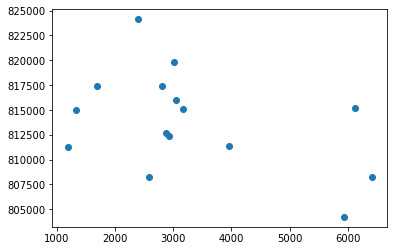

In [160]:
plt.scatter(fracs,sept_areas)
# plt.ylim(80_000, 83_000)

In [157]:
sept_areas

[804229.0,
 817419.0,
 815068.0,
 811248.0,
 811377.0,
 815999.0,
 824132.0,
 808261.0,
 808252.0,
 815185.0,
 817370.0,
 812665.0,
 812403.0,
 814976.0,
 819812.0]

In [12]:
lons = mask.get('lon'); lats = mask.get('lat')

In [45]:
fracs = []
coms = []
years = range(2006,2022)

for year in tqdm.tqdm(years):
    
    type_dir = '/media/robbie/TOSHIBA_EXT/OSISAF_type/type/'
    with Dataset(f'{type_dir}{year}/02/ice_type_nh_polstere-100_multi_{year}02281200.nc') as d:
        
#         print(d)
        
        ice_type = np.array(d['ice_type'][0])
        
        ice_type_ease = regrid(ice_type, osi_lons, osi_lats, lons, lats)
        
        ice_type_ease[lats>87.5] = 3
        ice_type_ease[ice_type_ease==4] = 3
        
        myi = ice_type_ease.copy()
        myi[myi != 3] = 0
        
    cartoplot(lons,lats,myi,color_scale=(0,3))

#     beaufort_myi = select_region('Beaufort',myi)

#     cartoplot(lons,lats,beaufort_myi,color_scale=(0,3))    
    
#     frac = np.nansum(beaufort_myi)/np.nansum(myi)
    frac = np.nansum(myi)
    
#     print(frac)
    
    fracs.append(frac)
    
#     break
    
# /media/robbie/TOSHIBA EXT/OSISAF_type/type/2006/02/ice_type_nh_polstere-100_multi_200602281200.nc
# /media/robbie/TOSHIBA EXT/OSISAF_type/type/2006/02/ice_type_nh_polstere-100_multi_200602281200.nc

  0%|          | 0/16 [00:01<?, ?it/s]


NameError: name 'beaufort_myi' is not defined

  0%|          | 0/16 [00:00<?, ?it/s]

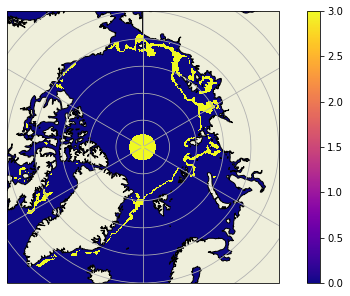

  6%|▋         | 1/16 [00:02<00:34,  2.29s/it]

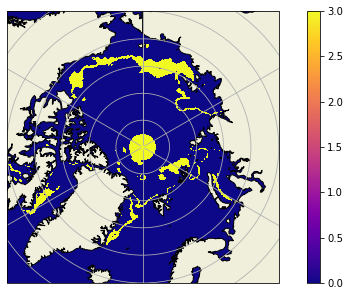

 12%|█▎        | 2/16 [00:04<00:31,  2.24s/it]

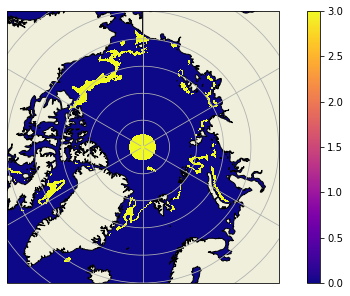

 19%|█▉        | 3/16 [00:06<00:29,  2.26s/it]

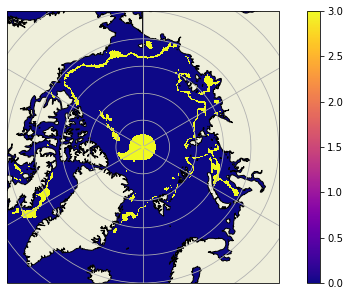

 25%|██▌       | 4/16 [00:08<00:26,  2.24s/it]

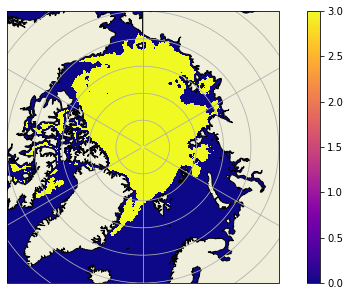

 31%|███▏      | 5/16 [00:11<00:24,  2.18s/it]

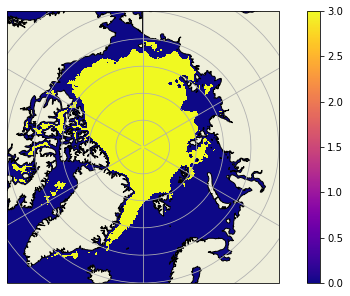

 38%|███▊      | 6/16 [00:13<00:22,  2.22s/it]

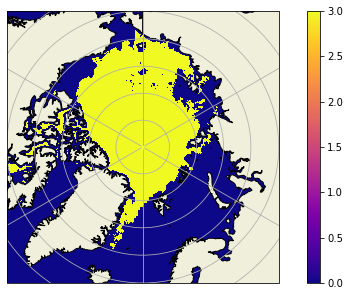

 44%|████▍     | 7/16 [00:15<00:20,  2.26s/it]

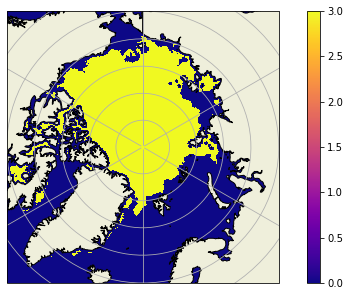

 50%|█████     | 8/16 [00:17<00:17,  2.24s/it]

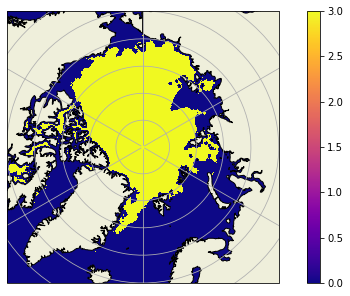

 56%|█████▋    | 9/16 [00:20<00:15,  2.20s/it]

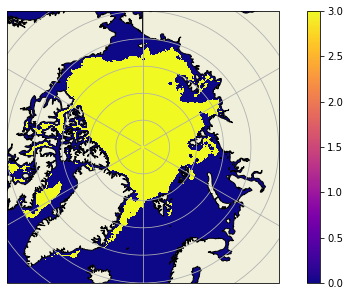

 62%|██████▎   | 10/16 [00:22<00:13,  2.27s/it]

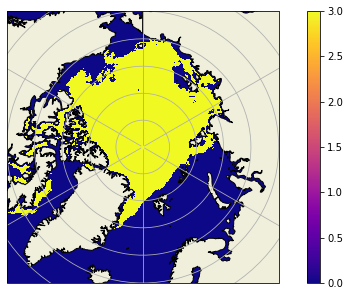

 69%|██████▉   | 11/16 [00:24<00:11,  2.23s/it]

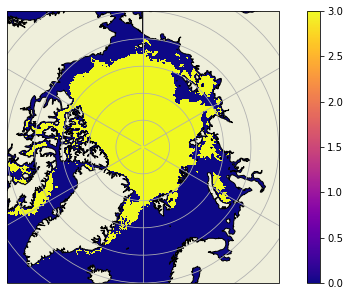

 75%|███████▌  | 12/16 [00:26<00:09,  2.26s/it]

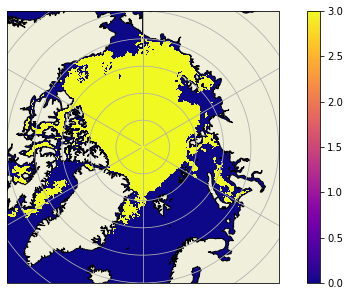

 81%|████████▏ | 13/16 [00:29<00:06,  2.27s/it]

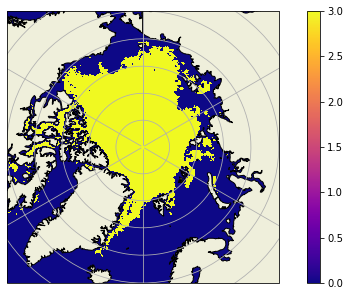

 88%|████████▊ | 14/16 [00:31<00:04,  2.28s/it]

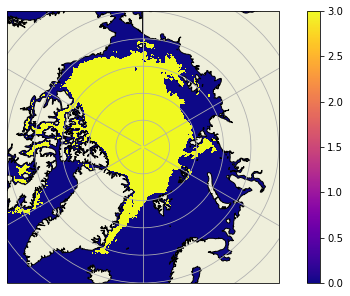

 94%|█████████▍| 15/16 [00:33<00:02,  2.24s/it]


FileNotFoundError: [Errno 2] No such file or directory: b'/media/robbie/TOSHIBA_EXT/OSISAF_type/type/2021/07/ice_type_nh_polstere-100_multi_202107131200.nc'

In [46]:
fracs = []
coms = []
years = range(2006,2022)

for year in tqdm.tqdm(years):
    
    type_dir = '/media/robbie/TOSHIBA_EXT/OSISAF_type/type/'
    with Dataset(f'{type_dir}{year}/07/ice_type_nh_polstere-100_multi_{year}07131200.nc') as d:
        
#         print(d)
        
        ice_type = np.array(d['ice_type'][0])
        
        ice_type_ease = regrid(ice_type, osi_lons, osi_lats, lons, lats)
        
        ice_type_ease[lats>87.5] = 3
        ice_type_ease[ice_type_ease==4] = 3
        
        myi = ice_type_ease.copy()
        myi[myi != 3] = 0
        
    cartoplot(lons,lats,myi,color_scale=(0,3))

#     beaufort_myi = select_region('Beaufort',myi)

#     cartoplot(lons,lats,beaufort_myi,color_scale=(0,3))    
    
#     frac = np.nansum(beaufort_myi)/np.nansum(myi)
    frac = np.nansum(myi)
    
#     print(frac)
    
    fracs.append(frac)
    
#     break
    
# /media/robbie/TOSHIBA EXT/OSISAF_type/type/2006/02/ice_type_nh_polstere-100_multi_200602281200.nc
# /media/robbie/TOSHIBA EXT/OSISAF_type/type/2006/02/ice_type_nh_polstere-100_multi_200602281200.nc

Text(0.5, 1.0, 'OSISAF ICE TYPE PRODUCT')

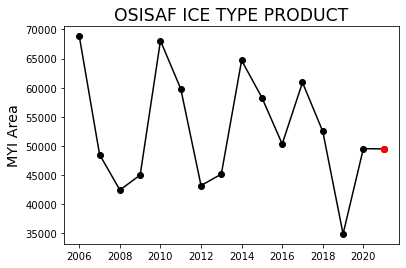

In [44]:
plt.plot(years,fracs,color='k',marker='o')
plt.scatter(years[-1],fracs[-1],color='r',marker='o',zorder=5)
plt.ylabel('MYI Area', fontsize='x-large')
plt.title('OSISAF ICE TYPE PRODUCT', fontsize='xx-large')

Text(0.5, 1.0, 'OSISAF ICE TYPE PRODUCT')

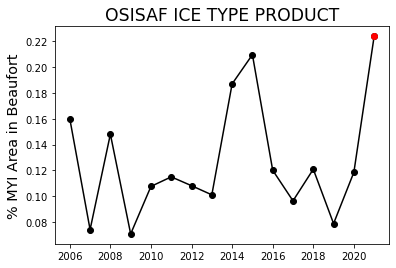

In [32]:
plt.plot(years,fracs,color='k',marker='o')
plt.scatter(years[-1],fracs[-1],color='r',marker='o',zorder=5)
plt.ylabel('% MYI Area in Beaufort', fontsize='x-large')
plt.title('OSISAF ICE TYPE PRODUCT', fontsize='xx-large')

(89.2, 89.8)

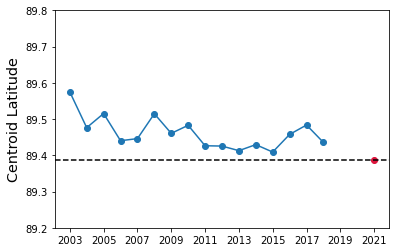

In [117]:
plt.plot(years,coms,marker='o')
# plt.scatter(2021,85.78,label='1st Dec')
plt.scatter(2021,89.387,label='1st Dec',color='crimson')
plt.axhline(89.387,color='k',ls='--')
plt.xticks(range(2003,2022,2))
plt.ylabel('Centroid Latitude',fontsize='x-large')
plt.ylim(89.2,89.8)

In [ ]:
import pickle

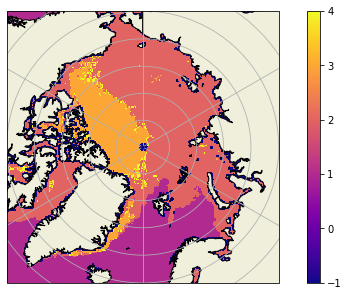

[-61557.78926795343] [-29143.187862140643]
([-64.66580966815701], [89.38750989155945])
8968.0
0.14674397859054417


In [111]:
today = pickle.load(open('/home/robbie/Dropbox/beaufort_sea/temporary_files/IT_20_2_21.p','rb'))

t_dat = regrid(today['dat'],today['lon'],today['lat'],lons,lats)

cartoplot(lons,lats,t_dat)

ice_type = t_dat

ice_type = select_region('basin',ice_type)

print(get_MYI_COM(ice_type))

all_MYI = select_type('MYI',ice_type,year=year,month=month)

beaufort_ice = select_region('Beaufort',ice_type)

beaufort_MYI = select_type('MYI',beaufort_ice,year=year,month=month)

print(np.nansum(all_MYI))

beaufort_frac_MYI = np.nansum(beaufort_MYI)/np.nansum(all_MYI)

print(beaufort_frac_MYI)

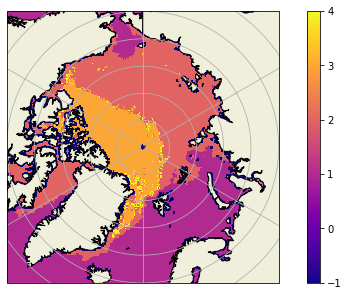

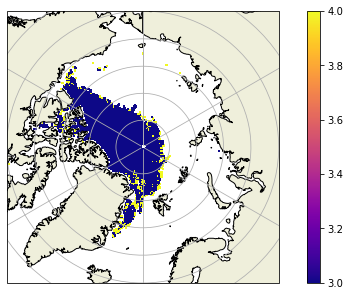

[-462688.1004139433] [76127.48295896627]


([-99.3433377916187], [85.78219845521286])

In [90]:
today = pickle.load(open('/home/robbie/Dropbox/beaufort_sea/temporary_files/IT_1_12_20.p','rb'))

t_dat = regrid(today['dat'],today['lon'],today['lat'],lons,lats)

cartoplot(lons,lats,t_dat)

ice_type = t_dat

all_MYI = np.ma.masked_where((ice_type<3), ice_type)
all_MYI = np.ma.filled(all_MYI,np.nan)

cartoplot(lons,lats,all_MYI)

get_MYI_COM(ice_type)

# beaufort_ice = select_region('Beaufort',ice_type)

# beaufort_MYI = select_type('MYI',beaufort_ice,year=year,month=month)

# print(np.nansum(all_MYI))

# beaufort_frac_MYI = np.nansum(beaufort_MYI)/np.nansum(all_MYI)

# print(beaufort_frac_MYI)

In [76]:
reload(tools)
import tools

In [79]:
from tools import lonlat_to_xy

[-462688.1004139433] [76127.48295896627]


([-99.3433377916187], [85.78219845521286])